---
THE TASK IS
* to resize images (now pdf but will have to compartmentalize) to fit paper e.g., pdf, without margins (or with)

In [1]:
import os, shutil
import numpy as np
import fitz
import matplotlib.pyplot as plt

In [4]:
path = "../Books/"
things = os.listdir(path)
things = [os.path.join(path, p) for p in things]
books = []
for thing in things:
    if ".pdf" in thing: # or ".epub" in thing:
        books.append(thing)

In [5]:
books

['../Books/The-Piano-Masterpieces-of-Maurice-Ravel.pdf']

In [6]:
def resize_pdf(iPath, oPath, margins):
    pdf = fitz.open(iPath)
    b4_merge = os.path.join(oPath, f"temp_for_{os.path.basename(iPath).split('.pdf')[0]}")
    if not os.path.isdir(b4_merge): os.makedirs(b4_merge)
    for pNum in range(pdf.page_count):
        page = pdf[pNum]
        if pNum > 0: # exlude cover . #1 needed its cover cropped. do it programatically next time
            page.set_cropbox(margins)
        cropped = fitz.open()
        cropped.insert_pdf(pdf, from_page=pNum, to_page=pNum)

        out= os.path.join(b4_merge, f"page_{pNum}.pdf")
        cropped.save(out)
        cropped.close()
        print(f"Page {pNum} done.", end="\r")
    merged = fitz.open()
    for pNum in range(pdf.page_count):
        merged.insert_pdf(fitz.open(os.path.join(b4_merge, f"page_{pNum}.pdf")))
    merged.save(os.path.join(oPath, f"{os.path.basename(iPath)}"))
    merged.close()
    shutil.rmtree(b4_merge) # clean dir
    pdf.close()
    print(f"\nBook {os.path.basename(iPath).split('.pdf')[0]} done.")

In [26]:
# Use this to zone in on your target margins
def plot_pdf(iPath, pNum, margins):
    pdf = fitz.open(iPath)
    page = pdf[pNum]
    pic = page.get_pixmap()
    im_dat = np.frombuffer(pic.samples, dtype=np.uint8).reshape((pic.h, pic.w, pic.n))
    plt.figure(figsize=(12, 8))
    print(type(im_dat))
    plt.imshow(im_dat, cmap="gray")
    plt.title(f"Crop region for page {pNum}")
    topx = [margins[0], margins[2]]
    topy = [margins[1], margins[1]]
    leftx = [margins[0], margins[0]]
    lefty = [margins[1], margins[3]]
    rightx = [margins[2], margins[2]]
    righty = [margins[1], margins[3]]
    bottomx = [margins[0], margins[2]]
    bottomy = [margins[3], margins[3]]
    plt.plot(topx, topy, linestyle='--', color='pink')
    plt.plot(leftx, lefty, linestyle='--', color='skyblue')
    plt.plot(rightx, righty, linestyle='--', color='orange')
    plt.plot(bottomx, bottomy, linestyle='--', color='purple')
    plt.legend()
    plt.show()
    return im_dat

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'numpy.ndarray'>


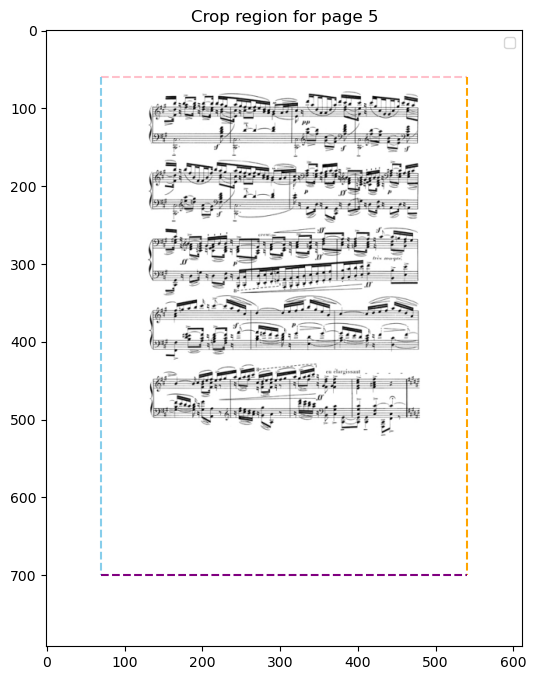

In [105]:
boundaries = (70, 60, 540, 700)
im_arr = plot_pdf(books[0], 5, boundaries)
# aaaaaaaaah that's asmr     maaaaaaaan hah not gonna show you a sheet

In [106]:
# We'll let the machine do the hard work
## test
cnt = 0
for x in range(im_arr.shape[1]):
    for y in range(im_arr.shape[0]):
        if im_arr[y, x, :].sum() != 255*3:
            cnt += 1
            print(f"non-whites coord x:{x}, y:{y}, color: {im_arr[y, x, :]}, cnt:{cnt}", end="\r")
## that's a lotta white space
## let's rectify that

# for exploring rows starting from the top: extracted y will be the top margin
            # (x start, x increment, y start, y increment)
posits = ["top", "bottom", "left", "right"]
switches = {posits[0]:(0, 1, 0, 1),
            posits[1]:(0, 1, im_arr.shape[0]-1, -1), 
            posits[2]:(0, 1, 0, 1), 
            posits[3]:(im_arr.shape[1]-1, -1, 0, 1)}

not_white = lambda x, y : im_arr[y, x, :].sum() != 255*3

margins = {
    posits[0]:0,
    posits[2]:0,
    posits[1]:0,
    posits[3]:0
}

for pos in posits:
    for x in range(switches[pos][0], im_arr.shape[1], switches[pos][1]):
        for y in range(switches[pos][2], im_arr.shape[0], switches[pos][3]):
            if not_white(x, y):
                switches[pos] = y
                x, y = im_arr.shape[1]-1-switches[pos][0], im_arr.shape[0]-1-switches[pos][2]
                print(x, y)

TypeError: 'int' object is not subscriptable

In [125]:
# books[0] -> (85, 60, 520, 660)
# books[1] -> (75, 60, 520, 680)
# books[2] -> (65, 65, 525, 710)
# books[3] -> (65, 65, 545, 710)
# i did not pirate these books! i didn't !

['../Books/jazz-ballads---jazz-piano-solos-series-volume-10.pdf',
 '../Books/Pop Standards - Jazz Piano Solos Series Volume 41.pdf',
 '../Books/best-smooth-jazz_-jazz-piano-solos-series-volume-50.pdf',
 '../Books/cocktail-jazz---jazz-piano-solos-series-volume-46.pdf']

In [17]:
out_dir = "../Books/processed"
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

resize_pdf(books[0], out_dir, (85, 60, 520, 660))
resize_pdf(books[1], out_dir, (75, 60, 520, 680))
resize_pdf(books[2], out_dir, (65, 65, 525, 710))
resize_pdf(books[3], out_dir, (65, 65, 545, 710))

Page 119 done.
Book Pop Standards - Jazz Piano Solos Series Volume 41 done.
